In [14]:
!pip install torch torchvision matplotlib scikit-learn tqdm


# **Upload  Dataset**

In [15]:
from google.colab import files
uploaded = files.upload()


Saving mnist.npz to mnist.npz


In [16]:
import os
print(os.listdir())


['.config', 'mnist.npz', 'data', 'sample_data']


# **Load the Dataset**

In [17]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split

# Load .npz file
data = np.load("mnist.npz")
x_train, y_train = data["x_train"], data["y_train"]
x_test, y_test = data["x_test"], data["y_test"]


## **Convert to PyTorch tensor**

In [18]:
x_train = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1) / 255.0
x_test = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1) / 255.0
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)


# **Split the Datase**

In [19]:
# Combine and split 70/15/15
X = torch.cat([x_train, x_test])
y = torch.cat([y_train, y_test])
dataset = TensorDataset(X, y)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(val_set, batch_size=128)
test_loader = DataLoader(test_set, batch_size=128)

print("Train:", len(train_set), "Val:", len(val_set), "Test:", len(test_set))

Train: 49000 Val: 10500 Test: 10500


# **Visualize a few sample images**

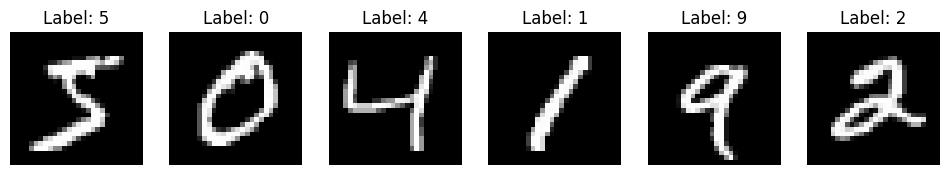

In [20]:
import matplotlib.pyplot as plt
# Function to show images
def show_images(images, labels, n=6):
    plt.figure(figsize=(12, 4))
    for i in range(n):
        plt.subplot(1, n, i+1)
        # images are tensors, remove channel dim and convert to numpy
        plt.imshow(images[i].squeeze().numpy(), cmap='gray')
        plt.title(f"Label: {labels[i].item()}")
        plt.axis('off')
    plt.show()

# Show first 6 training images
show_images(x_train, y_train, n=6)


# **show a batch from DataLoader**

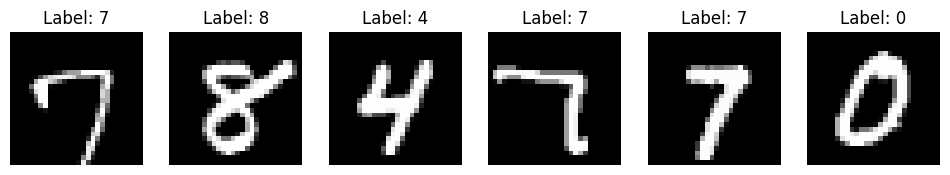

In [21]:
# Get a batch from train_loader
images, labels = next(iter(train_loader))
show_images(images, labels, n=6)


# **Import required modules**

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# **Define the CNN model**

In [23]:
class MyCNN(nn.Module):
    def __init__(self, x1=32, x2=64, x3=128, d=0.5, K=10):
        super(MyCNN, self).__init__()

        # First convolution + activation + maxpool
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=x1, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second convolution + activation + maxpool
        self.conv2 = nn.Conv2d(in_channels=x1, out_channels=x2, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Flatten will be done in forward pass
        # Fully connected layer
        self.fc1 = nn.Linear(x2 * 7 * 7, x3)  # 28x28 -> 14x14 -> 7x7 after pooling
        self.dropout = nn.Dropout(d)

        # Output layer
        self.fc2 = nn.Linear(x3, K)

    def forward(self, x):
        # Conv1 + ReLU + Pool
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        # Conv2 + ReLU + Pool
        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected + ReLU + Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        # Output layer
        x = self.fc2(x)  # logits
        return x


# **Initialize model, loss, optimizer**

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# **Train your CNN for 20 epochs**

Epoch 1/20, Train Loss: 0.3871, Val Loss: 0.0821
Epoch 2/20, Train Loss: 0.1091, Val Loss: 0.0541
Epoch 3/20, Train Loss: 0.0828, Val Loss: 0.0469
Epoch 4/20, Train Loss: 0.0691, Val Loss: 0.0384
Epoch 5/20, Train Loss: 0.0598, Val Loss: 0.0358
Epoch 6/20, Train Loss: 0.0521, Val Loss: 0.0338
Epoch 7/20, Train Loss: 0.0460, Val Loss: 0.0330
Epoch 8/20, Train Loss: 0.0425, Val Loss: 0.0359
Epoch 9/20, Train Loss: 0.0383, Val Loss: 0.0335
Epoch 10/20, Train Loss: 0.0335, Val Loss: 0.0334
Epoch 11/20, Train Loss: 0.0319, Val Loss: 0.0306
Epoch 12/20, Train Loss: 0.0294, Val Loss: 0.0327
Epoch 13/20, Train Loss: 0.0277, Val Loss: 0.0305
Epoch 14/20, Train Loss: 0.0230, Val Loss: 0.0301
Epoch 15/20, Train Loss: 0.0224, Val Loss: 0.0310
Epoch 16/20, Train Loss: 0.0208, Val Loss: 0.0355
Epoch 17/20, Train Loss: 0.0202, Val Loss: 0.0328
Epoch 18/20, Train Loss: 0.0185, Val Loss: 0.0344
Epoch 19/20, Train Loss: 0.0187, Val Loss: 0.0333
Epoch 20/20, Train Loss: 0.0178, Val Loss: 0.0348


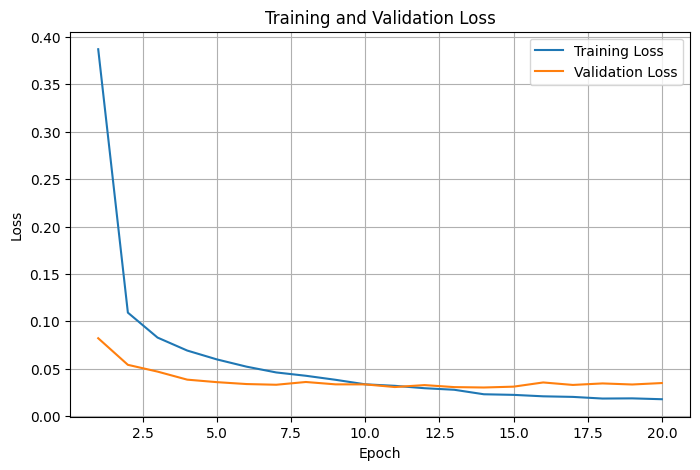

In [25]:
import matplotlib.pyplot as plt

num_epochs = 20
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * images.size(0)

    # Average training loss for this epoch
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Validation loss
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

# Plot training and validation loss
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


# **Define a function to compute predictions and accuracy**

In [26]:
import torch
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import numpy as np

def evaluate_model(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (preds == labels).sum().item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    return accuracy, np.array(all_labels), np.array(all_preds)


Evaluate on training and test sets

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training accuracy
train_acc, train_labels, train_preds = evaluate_model(model, train_loader, device)
print(f"Training Accuracy: {train_acc*100:.2f}%")

# Testing accuracy
test_acc, test_labels, test_preds = evaluate_model(model, test_loader, device)
print(f"Testing Accuracy: {test_acc*100:.2f}%")


Training Accuracy: 99.92%
Testing Accuracy: 99.33%


# **Confusion matrix, precision, and recall**

In [28]:
# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
print("Confusion Matrix:\n", cm)

# Precision and recall per class
precision = precision_score(test_labels, test_preds, average=None)
recall = recall_score(test_labels, test_preds, average=None)

print("\nPrecision per class:", precision)
print("Recall per class:", recall)

# Overall average metrics
precision_avg = precision_score(test_labels, test_preds, average='macro')
recall_avg = recall_score(test_labels, test_preds, average='macro')
print(f"\nAverage Precision: {precision_avg:.4f}")
print(f"Average Recall: {recall_avg:.4f}")


Confusion Matrix:
 [[1012    1    0    0    0    0    0    0    0    1]
 [   0 1225    3    0    0    0    0    1    0    0]
 [   1    0 1023    1    0    0    0    3    1    0]
 [   0    2    1 1007    0    1    0    0    1    1]
 [   0    0    0    0 1031    0    1    1    0    5]
 [   3    1    1    2    0  951    5    0    3    0]
 [   3    1    0    0    0    0 1030    0    1    0]
 [   0    1    2    0    2    0    0 1093    0    1]
 [   0    1    2    1    1    1    3    1 1059    2]
 [   1    1    0    0    1    1    0    2    1  999]]

Precision per class: [0.99215686 0.99351176 0.99127907 0.99604352 0.99613527 0.99685535
 0.99133782 0.99273388 0.9934334  0.9900892 ]
Recall per class: [0.99802761 0.99674532 0.9941691  0.994077   0.99325626 0.98447205
 0.99516908 0.99454049 0.98879552 0.99304175]

Average Precision: 0.9934
Average Recall: 0.9932


Choose the Pre-trained Model (AlexNet)

In [30]:
#  Load pretrained AlexNet
from torchvision import models
import torch.nn as nn
import torch

# Check GPU/CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load pretrained AlexNet
alexnet = models.alexnet(weights="IMAGENET1K_V1")
print(alexnet)


Using device: cuda
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features

Fine-tune AlexNet for the Dataset

In [33]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
from torchvision import datasets, transforms

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_data = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# Combine train + test
x_train = train_data.data.unsqueeze(1).float() / 255.0
y_train = train_data.targets
x_test = test_data.data.unsqueeze(1).float() / 255.0
y_test = test_data.targets

# Combine
X = torch.cat([x_train, x_test])
y = torch.cat([y_train, y_test])
dataset = TensorDataset(X, y)

# Split 70/15/15
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

# Dataloaders
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(val_set, batch_size=128)
test_loader = DataLoader(test_set, batch_size=128)

print(f"Train: {len(train_set)} | Val: {len(val_set)} | Test: {len(test_set)}")


Train: 49000 | Val: 10500 | Test: 10500


Using device: cuda
Starting training...
Epoch [1/20] Train Loss: 0.2936 | Val Loss: 0.0680
Epoch [2/20] Train Loss: 0.0640 | Val Loss: 0.0572
Epoch [3/20] Train Loss: 0.0436 | Val Loss: 0.0385
Epoch [4/20] Train Loss: 0.0357 | Val Loss: 0.0309
Epoch [5/20] Train Loss: 0.0271 | Val Loss: 0.0329
Epoch [6/20] Train Loss: 0.0230 | Val Loss: 0.0310
Epoch [7/20] Train Loss: 0.0210 | Val Loss: 0.0316
Epoch [8/20] Train Loss: 0.0210 | Val Loss: 0.0317
Epoch [9/20] Train Loss: 0.0172 | Val Loss: 0.0274
Epoch [10/20] Train Loss: 0.0130 | Val Loss: 0.0320
Epoch [11/20] Train Loss: 0.0129 | Val Loss: 0.0261
Epoch [12/20] Train Loss: 0.0131 | Val Loss: 0.0243
Epoch [13/20] Train Loss: 0.0121 | Val Loss: 0.0285
Epoch [14/20] Train Loss: 0.0086 | Val Loss: 0.0293
Epoch [15/20] Train Loss: 0.0099 | Val Loss: 0.0406
Epoch [16/20] Train Loss: 0.0105 | Val Loss: 0.0350
Epoch [17/20] Train Loss: 0.0084 | Val Loss: 0.0274
Epoch [18/20] Train Loss: 0.0074 | Val Loss: 0.0309
Epoch [19/20] Train Loss: 0.0080 

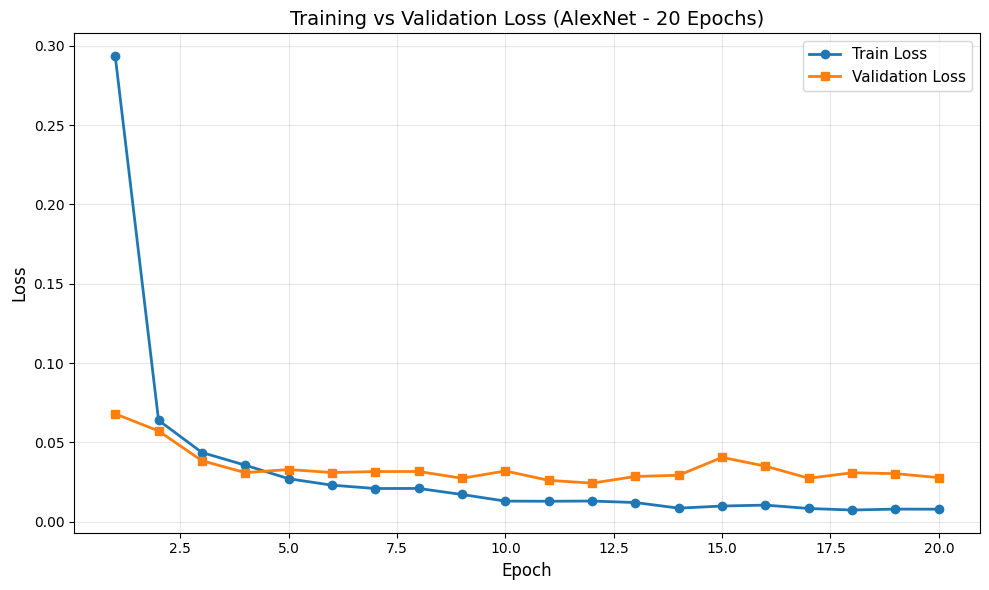

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models
import matplotlib.pyplot as plt

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# AlexNet model
alexnet = models.alexnet(weights=None)
alexnet.features[0] = nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2)
alexnet.classifier[6] = nn.Linear(4096, 10)
alexnet.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.parameters(), lr=1e-4)

num_epochs = 20
train_loss, val_loss = [], []

print("Starting training...")
for epoch in range(num_epochs):
    # Training phase
    alexnet.train()
    running_train_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        images = F.interpolate(images, size=(224, 224), mode='bilinear')

        optimizer.zero_grad()
        outputs = alexnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * images.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_loss.append(epoch_train_loss)

    # Validation phase
    alexnet.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            images = F.interpolate(images, size=(224, 224), mode='bilinear')
            outputs = alexnet(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_loss.append(epoch_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

# Save the model
torch.save(alexnet.state_dict(), 'alexnet_mnist.pth')
print("\nModel saved as 'alexnet_mnist.pth'")

# Plot loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss)+1), train_loss, marker='o', label='Train Loss', linewidth=2)
plt.plot(range(1, len(val_loss)+1), val_loss, marker='s', label='Validation Loss', linewidth=2)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training vs Validation Loss (AlexNet - 20 Epochs)", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

 Evaluate the fine-tuned model

Evaluating AlexNet on test set...

TEST ACCURACY: 99.39%

Classification Report:
              precision    recall  f1-score   support

           0     0.9933    0.9990    0.9961      1032
           1     0.9922    0.9965    0.9944      1152
           2     0.9943    0.9943    0.9943      1061
           3     0.9972    0.9945    0.9959      1091
           4     0.9961    0.9923    0.9942      1041
           5     0.9947    0.9926    0.9937       947
           6     0.9909    0.9929    0.9919       984
           7     0.9946    0.9929    0.9938      1123
           8     0.9919    0.9909    0.9914       992
           9     0.9935    0.9926    0.9930      1077

    accuracy                         0.9939     10500
   macro avg     0.9939    0.9939    0.9939     10500
weighted avg     0.9939    0.9939    0.9939     10500



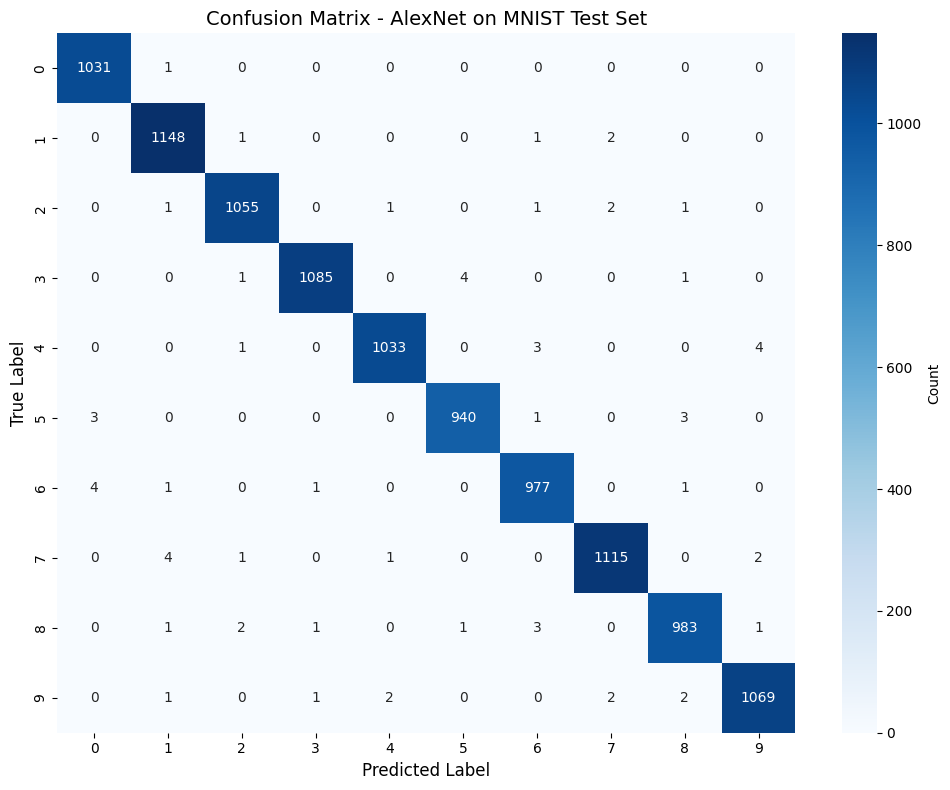


Per-Class Accuracy:
Digit 0: 99.90% (1031/1032)
Digit 1: 99.65% (1148/1152)
Digit 2: 99.43% (1055/1061)
Digit 3: 99.45% (1085/1091)
Digit 4: 99.23% (1033/1041)
Digit 5: 99.26% (940/947)
Digit 6: 99.29% (977/984)
Digit 7: 99.29% (1115/1123)
Digit 8: 99.09% (983/992)
Digit 9: 99.26% (1069/1077)

PERFORMANCE SUMMARY
Total Test Samples: 10500
Correct Predictions: 10436
Incorrect Predictions: 64
Overall Accuracy: 99.39%
Error Rate: 0.61%


In [36]:
import torch
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Evaluate on test set
print("Evaluating AlexNet on test set...")
alexnet.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        images = F.interpolate(images, size=(224, 224), mode='bilinear')

        outputs = alexnet(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Overall accuracy
accuracy = 100 * correct / total
print(f"\n{'='*50}")
print(f"TEST ACCURACY: {accuracy:.2f}%")
print(f"{'='*50}\n")

# Detailed classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds,
                          target_names=[str(i) for i in range(10)],
                          digits=4))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10),
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - AlexNet on MNIST Test Set', fontsize=14)
plt.tight_layout()
plt.show()

# Per-class accuracy
class_correct = [0] * 10
class_total = [0] * 10

for label, pred in zip(all_labels, all_preds):
    class_total[label] += 1
    if label == pred:
        class_correct[label] += 1

print("\n" + "="*50)
print("Per-Class Accuracy:")
print("="*50)
for i in range(10):
    acc = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
    print(f"Digit {i}: {acc:.2f}% ({class_correct[i]}/{class_total[i]})")

# Summary statistics
print("\n" + "="*50)
print("PERFORMANCE SUMMARY")
print("="*50)
print(f"Total Test Samples: {total}")
print(f"Correct Predictions: {correct}")
print(f"Incorrect Predictions: {total - correct}")
print(f"Overall Accuracy: {accuracy:.2f}%")
print(f"Error Rate: {100 - accuracy:.2f}%")

 **ResNet**

Train the fine-tuned model using the same training and testing data

Using device: cuda
Starting ResNet training...
Epoch [1/20] Train Loss: 0.1957 | Val Loss: 0.1247
Epoch [2/20] Train Loss: 0.0327 | Val Loss: 0.0478
Epoch [3/20] Train Loss: 0.0191 | Val Loss: 0.0506
Epoch [4/20] Train Loss: 0.0148 | Val Loss: 0.0839
Epoch [5/20] Train Loss: 0.0101 | Val Loss: 0.0409
Epoch [6/20] Train Loss: 0.0080 | Val Loss: 0.0266
Epoch [7/20] Train Loss: 0.0060 | Val Loss: 0.0353
Epoch [8/20] Train Loss: 0.0045 | Val Loss: 0.0320
Epoch [9/20] Train Loss: 0.0057 | Val Loss: 0.0542
Epoch [10/20] Train Loss: 0.0046 | Val Loss: 0.0375
Epoch [11/20] Train Loss: 0.0055 | Val Loss: 0.0636
Epoch [12/20] Train Loss: 0.0049 | Val Loss: 0.0549
Epoch [13/20] Train Loss: 0.0043 | Val Loss: 0.0347
Epoch [14/20] Train Loss: 0.0043 | Val Loss: 0.0241
Epoch [15/20] Train Loss: 0.0032 | Val Loss: 0.0489
Epoch [16/20] Train Loss: 0.0027 | Val Loss: 0.0400
Epoch [17/20] Train Loss: 0.0029 | Val Loss: 0.0303
Epoch [18/20] Train Loss: 0.0038 | Val Loss: 0.0403
Epoch [19/20] Train Loss: 

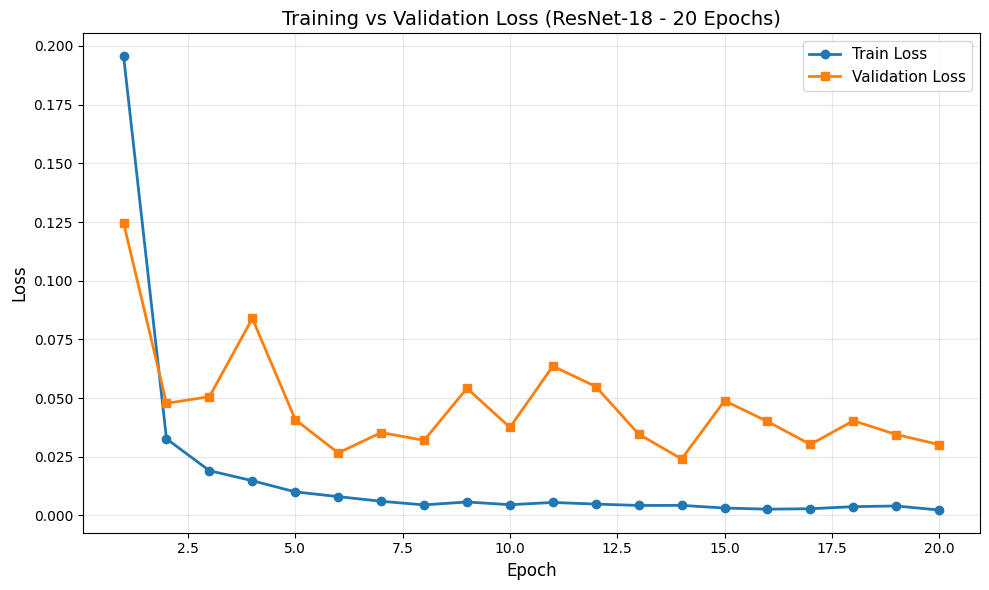

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models
import matplotlib.pyplot as plt

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ResNet-18 model
resnet = models.resnet18(weights=None)
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
resnet.fc = nn.Linear(resnet.fc.in_features, 10)
resnet.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=1e-4)

num_epochs = 20
train_loss, val_loss = [], []

print("Starting ResNet training...")
for epoch in range(num_epochs):
    # Training phase
    resnet.train()
    running_train_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        images = F.interpolate(images, size=(224, 224), mode='bilinear')

        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * images.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_loss.append(epoch_train_loss)

    # Validation phase
    resnet.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            images = F.interpolate(images, size=(224, 224), mode='bilinear')
            outputs = resnet(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_loss.append(epoch_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

# Save the model
torch.save(resnet.state_dict(), 'resnet_mnist.pth')
print("\nModel saved as 'resnet_mnist.pth'")

# Plot loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss)+1), train_loss, marker='o', label='Train Loss', linewidth=2)
plt.plot(range(1, len(val_loss)+1), val_loss, marker='s', label='Validation Loss', linewidth=2)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training vs Validation Loss (ResNet-18 - 20 Epochs)", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

Evaluate the fine-tuned model on the testing dataset and record the performance
 metrics

Evaluating ResNet on test set...

TEST ACCURACY: 99.36%

Classification Report:
              precision    recall  f1-score   support

           0     0.9942    0.9913    0.9927      1032
           1     0.9948    0.9965    0.9957      1152
           2     0.9972    0.9962    0.9967      1061
           3     0.9982    0.9945    0.9963      1091
           4     0.9858    0.9990    0.9924      1041
           5     0.9937    1.0000    0.9968       947
           6     0.9949    0.9929    0.9939       984
           7     0.9937    0.9884    0.9911      1123
           8     0.9939    0.9889    0.9914       992
           9     0.9898    0.9889    0.9893      1077

    accuracy                         0.9936     10500
   macro avg     0.9936    0.9937    0.9936     10500
weighted avg     0.9936    0.9936    0.9936     10500



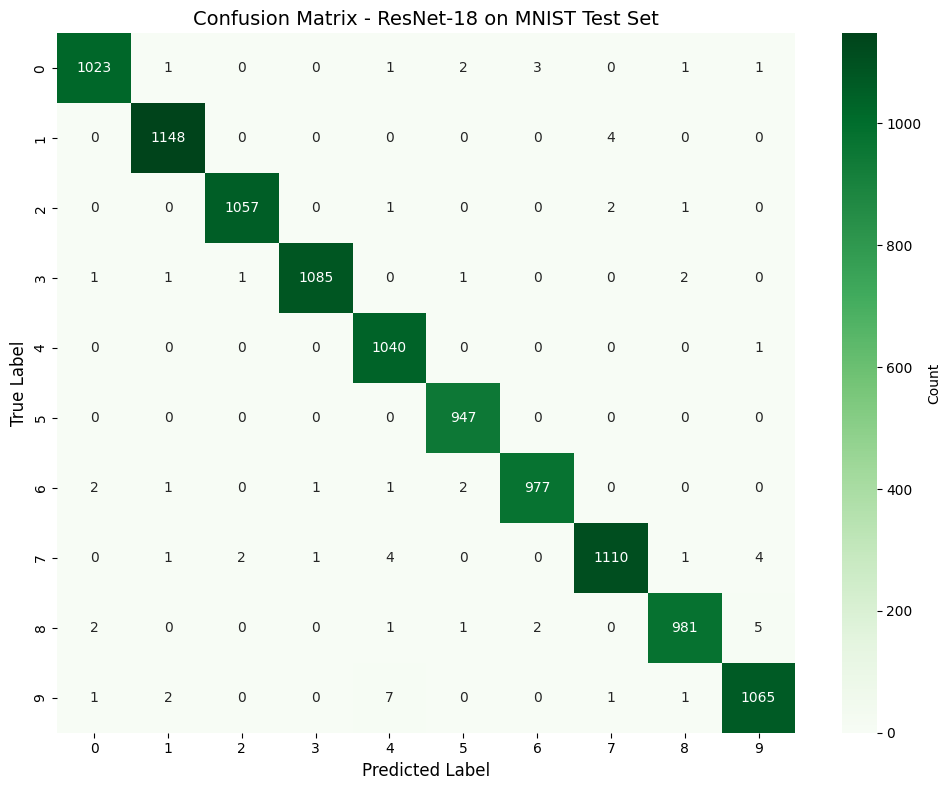


Per-Class Accuracy:
Digit 0: 99.13% (1023/1032)
Digit 1: 99.65% (1148/1152)
Digit 2: 99.62% (1057/1061)
Digit 3: 99.45% (1085/1091)
Digit 4: 99.90% (1040/1041)
Digit 5: 100.00% (947/947)
Digit 6: 99.29% (977/984)
Digit 7: 98.84% (1110/1123)
Digit 8: 98.89% (981/992)
Digit 9: 98.89% (1065/1077)

PERFORMANCE SUMMARY
Total Test Samples: 10500
Correct Predictions: 10433
Incorrect Predictions: 67
Overall Accuracy: 99.36%
Error Rate: 0.64%


In [38]:
import torch
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Evaluate on test set
print("Evaluating ResNet on test set...")
resnet.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        images = F.interpolate(images, size=(224, 224), mode='bilinear')

        outputs = resnet(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Overall accuracy
accuracy = 100 * correct / total
print(f"\n{'='*50}")
print(f"TEST ACCURACY: {accuracy:.2f}%")
print(f"{'='*50}\n")

# Detailed classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds,
                          target_names=[str(i) for i in range(10)],
                          digits=4))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=range(10), yticklabels=range(10),
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - ResNet-18 on MNIST Test Set', fontsize=14)
plt.tight_layout()
plt.show()

# Per-class accuracy
class_correct = [0] * 10
class_total = [0] * 10

for label, pred in zip(all_labels, all_preds):
    class_total[label] += 1
    if label == pred:
        class_correct[label] += 1

print("\n" + "="*50)
print("Per-Class Accuracy:")
print("="*50)
for i in range(10):
    acc = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
    print(f"Digit {i}: {acc:.2f}% ({class_correct[i]}/{class_total[i]})")

# Summary statistics
print("\n" + "="*50)
print("PERFORMANCE SUMMARY")
print("="*50)
print(f"Total Test Samples: {total}")
print(f"Correct Predictions: {correct}")
print(f"Incorrect Predictions: {total - correct}")
print(f"Overall Accuracy: {accuracy:.2f}%")
print(f"Error Rate: {100 - accuracy:.2f}%")